# Main task: Experiments

## 1) PCA

In [54]:
import matplotlib.pyplot as plt
from PIL import Image
import vlad_emb
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.decomposition import PCA
import util
from os.path import join

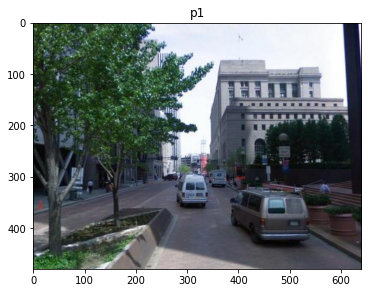

In [55]:
p1 = Image.open('./sample_pitt250k_3/q1.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)

In [74]:
dir_lst = util.get_directories('sample_3rscan_10', True)
emb_lst = []
test = False
for dir in dir_lst:
    metaf_path = join('sample_3rscan_10',dir,'sequence','_info.txt')
    metaf = open(metaf_path,"r+")
    metaf.seek(0)
    metaf_lines = metaf.readlines()
    size = int(metaf_lines[-1].split()[-1])
    print('scene: {} size: {}'.format(dir, size))
    metaf.close()
    num_v = 30 # number of vertices in each graph
    step = size // num_v # uniform interval length 
    frames = ['0'*(6-len(str(x)))+str(x) for x in range(0, size, step)]
    for i, frame in enumerate(frames):
        # each vertex
        rgb_file = 'frame-' + frame + '.color.jpg'
        rgb_file_path = join('sample_3rscan_10', dir, 'sequence', rgb_file)
        # 1 get vlad encoding 
        img = Image.open(rgb_file_path)
        emb = torch.flatten(vlad_emb.get_vlad_emb(img))
        emb_lst.append(emb)
        if test: print('vlad_embbeding: {}'.format(emb.shape))

Directories in ' sample_3rscan_10 ' :
['0ad2d3a7-79e2-2212-9a1b-8737842a24e2', '0ad2d382-79e2-2212-98b3-641bf9d552c1', '0ad2d3a5-79e2-2212-9a9e-2502a05fa678', '0ad2d3a1-79e2-2212-9b99-a96495d9f7fe', '0ad2d3a3-79e2-2212-9a51-9094be707ec2', '0ad2d39d-79e2-2212-99aa-1e95c5b94289', '0ad2d38f-79e2-2212-98d2-9b5060e5e9b5', '0ad2d39b-79e2-2212-99ae-830c292cd079', '0ad2d384-79e2-2212-9b18-72b44eb5463f', '0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca']
scene: 0ad2d3a7-79e2-2212-9a1b-8737842a24e2 size: 161
scene: 0ad2d382-79e2-2212-98b3-641bf9d552c1 size: 340
scene: 0ad2d3a5-79e2-2212-9a9e-2502a05fa678 size: 97
scene: 0ad2d3a1-79e2-2212-9b99-a96495d9f7fe size: 70
scene: 0ad2d3a3-79e2-2212-9a51-9094be707ec2 size: 99
scene: 0ad2d39d-79e2-2212-99aa-1e95c5b94289 size: 133
scene: 0ad2d38f-79e2-2212-98d2-9b5060e5e9b5 size: 365
scene: 0ad2d39b-79e2-2212-99ae-830c292cd079 size: 157
scene: 0ad2d384-79e2-2212-9b18-72b44eb5463f size: 139
scene: 0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca size: 523


(328, 32768)


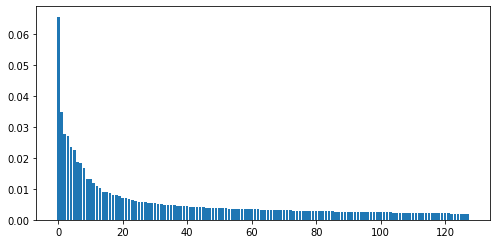

In [99]:
X = torch.stack(emb_lst).numpy()
print(X.shape)
pca = PCA(n_components=128)
pca.fit(X)
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# List of data points
data = pca.explained_variance_ratio_
x_axis = [x for x in range(len(data))]

# Plot bar chart with data points
plt.bar(x_axis, data)

# Display the plot
plt.show()

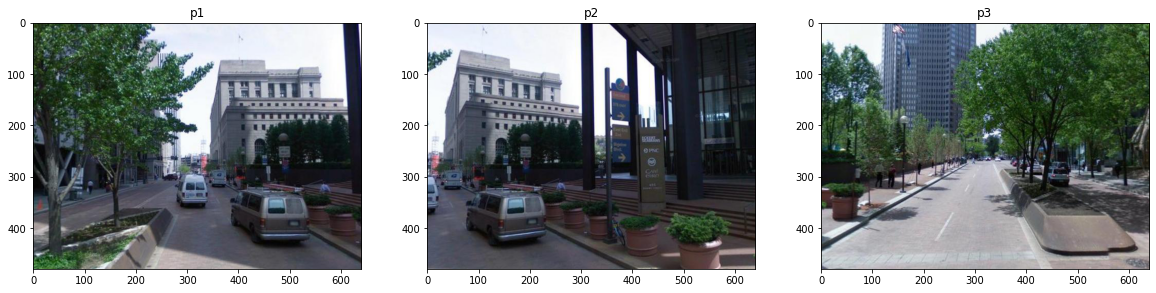

In [88]:
import matplotlib.pyplot as plt
from PIL import Image
p1 = Image.open('./sample_pitt250k_3/q1.jpg')
p2 = Image.open('./sample_pitt250k_3/q2.jpg')
p3 = Image.open('./sample_pitt250k_3/q3.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)
plt.subplot(1, 3, 2)
plt.title('p2')
plt.imshow(p2)
plt.subplot(1, 3, 3)
plt.title('p3')
plt.imshow(p3)

In [89]:
p1_vlad = vlad_emb.get_vlad_emb(p1)
p2_vlad = vlad_emb.get_vlad_emb(p2)
p3_vlad = vlad_emb.get_vlad_emb(p3)

In [94]:
p1_vlad_32 = torch.from_numpy(pca.transform(p1_vlad))
p2_vlad_32 = torch.from_numpy(pca.transform(p2_vlad))
p3_vlad_32 = torch.from_numpy(pca.transform(p3_vlad))
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_similar = cos(p1_vlad_32, p2_vlad_32)
output_diff = cos(p1_vlad_32, p3_vlad_32)
print('Cosine Similarity for 128 emb:\nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))

print('')

output_similar = cos(p1_vlad, p2_vlad)
output_diff = cos(p1_vlad, p3_vlad)
print('Cosine Similarity for 32768 emb:\nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))

Cosine Similarity for 128 emb:
for similar scenes: tensor([0.7818], dtype=torch.float64), 
for different scenes: tensor([0.6241], dtype=torch.float64)

Cosine Similarity for 32768 emb:
for similar scenes: tensor([0.3917]), 
for different scenes: tensor([0.2119])


## 2) Visualize graph

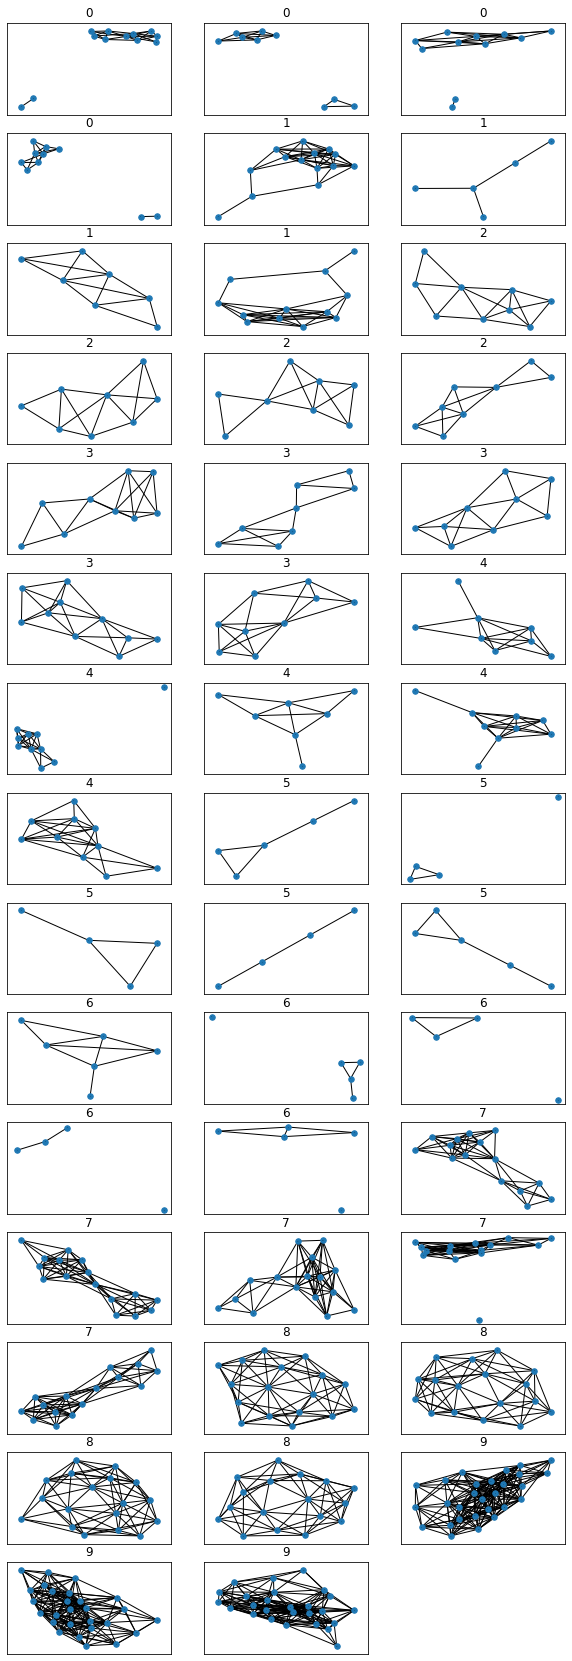

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
f = open('pytorch_DGCNN-master/data/DEMO10/DEMO10.txt', 'r')
num_graphs = int(f.readline())
num_columns = 3
num_rows = (num_graphs // num_columns) + 1
# print(num_graphs)
plt.figure(figsize=(10, 30))
for i in range(num_graphs):
    # for one graph
    g_info = f.readline().split()
    num_vertices = int(g_info[0])
    label = g_info[1]
#     print(num_vertices)
    G = nx.Graph()
    for j in range(num_vertices):
        # for one vertex
        vertex_info = f.readline().split()
        num_nbs = int(vertex_info[1])
        if num_nbs == 0:
            G.add_node(j)
        else:
            for k in range(2, num_nbs + 2):
                G.add_edge(j, int(vertex_info[k]))
    plt.subplot(num_rows, num_columns, i+1)
    plt.title(label)
    options = {
    "font_size": 1,
    "node_size": 30,
#     "node_color": "white",
#     "edgecolors": "black",
#     "linewidths": 5,
#     "width": 5,
    }
    nx.draw_networkx(G, **options)
f.close()

## 3) Object vertex focusing on 

In [2]:
# Get objects of interest 
objects = []
objects_of_interest = []
with open('objects_and_frequency.txt', 'r') as f:
    objects = f.readlines()
for object in objects:
    freq = int(object.split(",")[1])
    obj = object.split(",")[0]
    if freq > 100:
        objects_of_interest.append(obj)
num_objects_of_interest = len(objects_of_interest)

print(objects_of_interest, num_objects_of_interest)

['kitchen cabinet', 'box', 'sink', 'shelf', 'heater', 'kitchen counter', 'stove', 'blinds', 'commode', 'windowsill', 'lamp', 'radiator', 'clutter', 'towel', 'mirror', 'plant', 'toilet', 'door', 'table', 'chair', 'sofa', 'coffee table', 'stool', 'picture', 'trash can', 'item', 'bag', 'vase', 'pillow', 'monitor', 'pc', 'backpack', 'armchair', 'desk', 'light', 'counter', 'curtain', 'bed', 'rack', 'tv stand', 'tv', 'frame', 'blanket', 'bath cabinet', 'basket', 'clothes', 'bench', 'cushion', 'decoration', 'bucket', 'nightstand', 'couch', 'stand', 'wardrobe', 'shoes'] 55


In [7]:
# Construct one-hot vector
import torch
import numpy as np
a = np.array([x for x in range(num_objects_of_interest)])
one_hots = np.zeros((a.size, a.max()+1))
one_hots[np.arange(a.size),a] = 1
one_hots = torch.from_numpy(one_hots).int()
print(one_hots)

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)


In [5]:
# Associate objects of interest with their one-hot class
obj_dic = {}
for i in range(num_objects_of_interest):
    obj_dic[objects_of_interest[i]] = one_hots[i]
print(obj_dic["pillow"])
"pillow" in obj_dic.keys()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


True

In [7]:
import util
util.get_object_info_json('3rscan/0a4b8ef6-a83a-21f2-8672-dce34dd0d7ca/semseg.v2.json', obj_dic)

[(tensor([ 0.3587,  0.3052, -1.1691]),
  -1,
  tensor([ 0.0000e+00, -2.2204e-16,  1.0000e+00])),
 (tensor([ 1.8113, -0.8993, -0.1680]),
  -1,
  tensor([-5.3626e-01, -8.4405e-01, -1.8742e-16])),
 (tensor([-1.0545,  2.3471, -0.6129]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
  tensor([ 9.5497e-01, -2.9670e-01, -6.5881e-17])),
 (tensor([-0.0219,  1.8741, -0.6107]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
  tensor([-5.8108e-01, -8.1385e-01, -1.8071e-16])),
 (tensor([ 0.0342,  1.1674, -0.9846]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## 3.1) Build data.txt

In [2]:
import util
util.build_dataset(rooms_path='sample_rooms_10.txt', target_name='DEMO10', 
                pos_ind=0, feat_ind=1, base=0, method=0, ratio=1)
!head -10 ./pytorch_DGCNN-master/data/DEMO10/DEMO10.txt

44
12 0
0 5 1 4 6 7 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 4 0 6 7 10 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 1 9 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 5 4 5 6 10 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 8 0 3 5 6 7 8 10 11 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 5 3 4 6 8 11 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
0 7 0 1 3 4 5 8 11 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 4 0 1 4 10 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0

## 3.2) Build up cross validation

In [4]:
import util
util.build_cv_split_10fold('DEMO10', 44, 5)
!cat ./pytorch_DGCNN-master/data/DEMO10/10fold_idx/test_idx-1.txt

42
27
1
6
38


## 3.3) Run DGCNN

In [5]:
%cd pytorch_DGCNN-master
!pwd

/home/igor/Desktop/tao/tisl/tisl_localization_22s/pytorch_DGCNN-master
/home/igor/Desktop/tao/tisl/tisl_localization_22s/pytorch_DGCNN-master


In [12]:
!./run_DGCNN.sh DEMO10 3 5

3
CUDA_VISIBLE_DEVICES=0 python main.py       -seed 1       -data DEMO10       -fold 3       -learning_rate 0.00001       -num_epochs 50       -hidden 128       -latent_dim 32-32-32-1       -sortpooling_k 0.6       -out_dim 0       -batch_size 1       -gm DGCNN       -mode gpu       -dropout True       -test_number 5
====== begin of gnn configuration ======
| msg_average = 0
======   end of gnn configuration ======
Namespace(batch_size=1, conv1d_activation='ReLU', data='DEMO10', dropout=True, edge_feat_dim=0, extract_features=False, feat_dim=0, fold=3, gm='DGCNN', hidden=128, latent_dim=[32, 32, 32, 1], learning_rate=1e-05, max_lv=4, mode='gpu', num_class=0, num_epochs=50, out_dim=0, printAUC=False, seed=1, sortpooling_k=0.6, test_number=5)
loading data
# classes: 10
# maximum node tag: 1
# train: 39, # test: 5
k used in SortPooling is: 10
Initializing DGCNN
loss: 2.33278 acc: 0.00000: 100%|████████████| 39/39 [00:00<00:00, 45.64batch/s]
average training of epoch 0: loss 2.29777 acc 0.

loss: 2.30653 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 228.78batch/s]
average training of epoch 24: loss 2.30123 acc 0.05128 auc 0.00000
loss: 2.34291 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 425.42batch/s]
average test of epoch 24: loss 2.31594 acc 0.00000 auc 0.00000
loss: 2.26394 acc: 1.00000: 100%|███████████| 39/39 [00:00<00:00, 164.32batch/s]
average training of epoch 25: loss 2.28999 acc 0.23077 auc 0.00000
loss: 2.34461 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 440.29batch/s]
average test of epoch 25: loss 2.31719 acc 0.00000 auc 0.00000
loss: 2.35222 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 194.86batch/s]
average training of epoch 26: loss 2.29811 acc 0.10256 auc 0.00000
loss: 2.34582 acc: 0.00000: 100%|█████████████| 5/5 [00:00<00:00, 432.43batch/s]
average test of epoch 26: loss 2.31808 acc 0.00000 auc 0.00000
loss: 2.28507 acc: 0.00000: 100%|███████████| 39/39 [00:00<00:00, 197.35batch/s]
average training of epoch 27: loss 2.29071 